In [ ]:
# | default_exp analyses.rspc
%load_ext autoreload
%autoreload 2

 # Relative Serial Position Curve

 Compute a serial position curve where each recall is scored “correct” if it is exactly one position after the previous recall
 (previous + 1), with the first recall scored relative to position 0 (so only a recall of study position 1 is correct).

In [ ]:
# | export

from typing import Optional, Sequence

import jax.numpy as jnp
from jax import jit, lax, vmap
from matplotlib import rcParams  # type: ignore
from matplotlib.axes import Axes
from simple_pytree import Pytree

from jaxcmr.helpers import apply_by_subject, find_max_list_length
from jaxcmr.plotting import init_plot, plot_data, set_plot_labels
from jaxcmr.repetition import all_study_positions
from jaxcmr.typing import Array, Bool, Float, Int_, Integer, RecallDataset

## Calculation

In [ ]:
# | exports


class Tabulation(Pytree):
    "A tabulation of transitions between items during recall of a study list."

    def __init__(
        self,
        presentation: Integer[Array, " study_events"],
        first_recall: Int_,
        size: int = 3,
    ):
        self.list_length = presentation.size
        self.all_positions = jnp.arange(1, self.list_length + 1, dtype=int)
        self.size = size
        self.item_study_positions = lax.map(
            lambda i: all_study_positions(i, presentation, size),
            self.all_positions,
        )
        self.previous = self.item_study_positions[first_recall - 1]
        self.recalled = (
            jnp.zeros(self.list_length, dtype=bool)
            .at[0]
            .set(jnp.any(self.previous == 1))
        )

    def tabulate_transition(self, recall: Int_) -> Bool[Array, " positions"]:
        "Returns whether recall study positions make it a +1 neighbor of the previous item."
        recall_positions = self.item_study_positions[recall - 1]  # 0-padded
        prev_plus_one = jnp.array(jnp.where(self.previous > 0, self.previous + 1, 0))

        # True where a real recall position equals a real prev_pos + 1
        matches = (
            (recall_positions[:, None] == prev_plus_one[None, :])
            & (recall_positions[:, None] > 0)
            & (prev_plus_one[None, :] > 0)
        )

        matched_rows = jnp.any(matches, axis=1)
        positions_to_flag = jnp.array(jnp.where(matched_rows, recall_positions, 0))
        idx = jnp.clip(positions_to_flag - 1, 0, self.list_length - 1)
        return jnp.zeros_like(self.recalled).at[idx].set(positions_to_flag > 0)

    def tabulate(self, recall: Int_) -> "Tabulation":
        "Tabulates whether this recall occurred after its -1 serial neighbor."
        return self.replace(
            previous=self.item_study_positions[recall - 1],
            recalled=self.recalled | self.tabulate_transition(recall),
        )


def tabulate_trial(
    trial: Integer[Array, " recall_events"],
    presentation: Integer[Array, " study_events"],
    size: int = 3,
) -> Float[Array, " study_events"]:
    init = Tabulation(presentation, trial[0], size)
    tab = lax.fori_loop(1, trial.size, lambda i, t: t.tabulate(trial[i]), init)
    return tab.recalled


def relative_spc(
    recalls: Integer[Array, " trial_count recall_positions"],
    presentations: Integer[Array, " trial_count study_positions"],
    list_length: Optional[int] = None,
    size: int = 3,
) -> Float[Array, " study_positions"]:
    """Returns relative-order serial recall accuracy as a function of study position.

    Args:
        recalls: trial by recall position array of recalled items. 1-indexed; 0 for no recall.
        presentations: trial by study position array of presented items. 1-indexed.
        list_length: the length of the study list.
        size: maximum number of study positions an item can be presented at.
    """
    scores = vmap(tabulate_trial, in_axes=(0, 0, None))(recalls, presentations, size)
    return jnp.mean(scores, axis=0)

 ## Plotting

In [ ]:
# | exports


def plot_relative_spc(
    datasets: Sequence[RecallDataset] | RecallDataset,
    trial_masks: Sequence[Bool[Array, " trial_count"]] | Bool[Array, " trial_count"],
    distances: Optional[Float[Array, " word_count word_count"]] = None,
    color_cycle: Optional[list[str]] = None,
    labels: Optional[Sequence[str]] = None,
    contrast_name: Optional[str] = None,
    axis: Optional[Axes] = None,
    size: int = 3,
) -> Axes:
    """Returns Axes object with plotted serial position curve for datasets and trial masks.

    Args:
        datasets: Datasets containing trial data to be plotted.
        trial_masks: Masks to filter trials in datasets.
        color_cycle: List of colors for plotting each dataset.
        distances: Unused, included for compatibility with other plotting functions.
        labels: Names for each dataset for legend, optional.
        contrast_name: Name of contrast for legend labeling, optional.
        axis: Existing matplotlib Axes to plot on, optional.
        size: Maximum number of study positions an item can be presented at.
    """
    axis = init_plot(axis)

    if color_cycle is None:
        color_cycle = [each["color"] for each in rcParams["axes.prop_cycle"]]

    if labels is None:
        labels = [""] * len(datasets)

    if isinstance(datasets, dict):
        datasets = [datasets]

    if isinstance(trial_masks, jnp.ndarray):
        trial_masks = [trial_masks]

    max_list_length = find_max_list_length(datasets, trial_masks)
    for data_index, data in enumerate(datasets):
        subject_values = jnp.vstack(
            apply_by_subject(
                data,
                trial_masks[data_index],
                jit(relative_spc, static_argnames=("size")),
                size,
            )
        )

        color = color_cycle.pop(0)
        plot_data(
            axis,
            jnp.arange(max_list_length, dtype=int) + 1,
            subject_values,
            labels[data_index],
            color,
        )

    set_plot_labels(axis, "Study Position", "Recall Rate", contrast_name)
    return axis

 ## Tests

In [ ]:
# | code-summary: all_study_positions retrieves the study positions of a given recall item
pres = jnp.array([1, 2, 1])
out = all_study_positions(1, pres, 3)
assert jnp.array_equal(out, jnp.array([1, 3, 0]))

In [ ]:
# | code-summary:  Perfect forward recall
pres = jnp.array([1, 2, 3])
rec = jnp.array([1, 2, 3])
assert jnp.array_equal(tabulate_trial(rec, pres, 3), jnp.array([True, True, True]))

In [ ]:
# | code-summary: Out-of-order start
pres = jnp.array([1, 2, 3])
rec = jnp.array([2, 3, 1])
assert jnp.array_equal(tabulate_trial(rec, pres, 3), jnp.array([False, False, True]))

In [ ]:
# | code-summary: Repetitions, all satisfied
pres = jnp.array([1, 2, 1])
rec = jnp.array([1, 2, 1])
assert jnp.array_equal(tabulate_trial(rec, pres), jnp.array([True, True, True]))

In [ ]:
# | code-summary: multi-trial example with no repetitions and one error
recalls = jnp.array([[1, 2, 3], [1, 2, 1]])
presents = jnp.array([[1, 2, 3], [1, 2, 3]])
out = relative_spc(recalls, presents, 3)
assert jnp.allclose(out, jnp.array([1.0, 1.0, 0.5]))

In [ ]:
# | code-summary: Longer recall list with repeats
pres = jnp.array([1, 2, 3, 4])
rec = jnp.array([1, 1, 2, 3, 4, 3, 4])
assert jnp.array_equal(tabulate_trial(rec, pres), jnp.array([True, True, True, True]))

In [ ]:
# | code-summary: zero-padding at end of recalls
pres = jnp.array([1, 2, 3, 4])
rec = jnp.array([1, 2, 3, 4, 0, 0])
assert jnp.array_equal(
    tabulate_trial(rec, pres, size=1), jnp.array([True, True, True, True])
)

 ## Examples

In [ ]:
import os

from jaxcmr.helpers import find_project_root, generate_trial_mask, load_data

<Axes: xlabel='Study Position', ylabel='Recall Rate'>

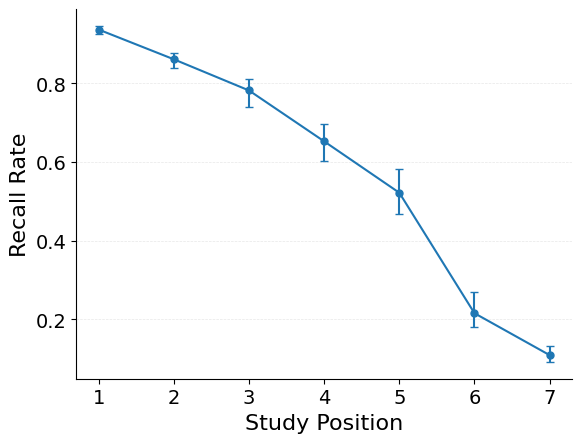

In [ ]:
run_tag = "RepCRP"
data_name = "Gordon2021"
data_query = "data['condition'] == 2"
data_path = os.path.join(find_project_root(), "data/Gordon2021.h5")

# set up data structures
data = load_data(data_path)
recalls = data["recalls"]
presentations = data["pres_itemnos"]
list_length = data["listLength"][0].item()
trial_mask = generate_trial_mask(data, data_query)

# plot SPC
plot_relative_spc(data, trial_mask)


Array([0.21666667, 0.2547619 , 0.15476191, 0.1       , 0.08333334,
       0.09047619, 0.07142857, 0.06190477, 0.04761905, 0.04285714,
       0.05714286, 0.0452381 , 0.04761905, 0.06666667, 0.04761905,
       0.04761905, 0.06904762, 0.05      , 0.05476191, 0.04047619,
       0.05714286, 0.04761905, 0.02619048, 0.0452381 , 0.06666667,
       0.05      , 0.06904762, 0.05476191, 0.0452381 , 0.06190477,
       0.06428572, 0.04285714, 0.05      , 0.04761905, 0.05952381,
       0.0452381 , 0.06666667, 0.05952381, 0.07857143, 0.0952381 ],      dtype=float32)

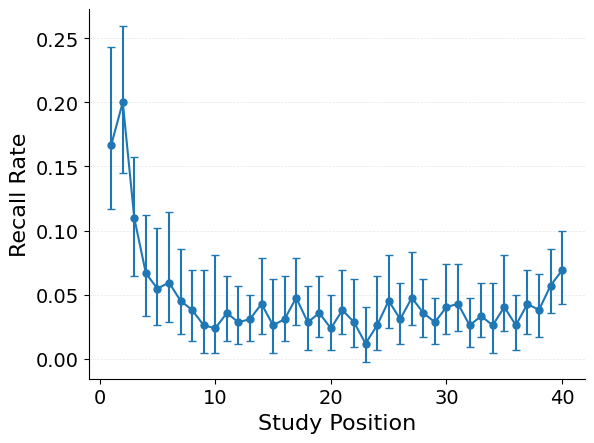

In [ ]:
# parameters
run_tag = "SPC"
data_name = "LohnasKahana2014"
data_query = "data['list_type'] == 1"
data_path = os.path.join(find_project_root(), "data/LohnasKahana2014.h5")

# set up data structures
data = load_data(data_path)
recalls = data["recalls"]
presentations = data["pres_itemnos"]
list_length = data["listLength"][0].item()
trial_mask = generate_trial_mask(data, data_query)

# plot SPC
plot_relative_spc(data, trial_mask)
jit(relative_spc, static_argnames=("size", "list_length"))(
    recalls[trial_mask], presentations[trial_mask], list_length
)